# Práctico 1: Recomendación de Artistas

En este práctico trabajaremos con el conjuto de datos de [LastFM](https://grouplens.org/datasets/hetrec-2011/) para el desarrollo de un sistema de recomendación que, dado el nombre de un artista musical, devuelve una lista de artistas "similares".

Para el práctico utilizaremos el conjunto de datos de LastFM que consiguieron del [notebook de instalación](./instalacion.ipynb). Se recomienda leer el [Readme](http://files.grouplens.org/datasets/hetrec2011/hetrec2011-lastfm-readme.txt) de los datos para saber más sobre que información contiene cada archivo.

La idea del práctico es hacer un análisis muy sencillo del conjunto de datos y desarrollar un sistema de recomendación basado en filtrado colaborativo (usando Surpr!se), a partir de los datos existentes.

In [1]:
#paquetería...

import pandas as pd
import numpy as np


In [2]:
#artist_data...

artist_data = pd.read_csv('C:/Users/Flavio/Downloads/hetrec2011-lastfm-2k/artists.dat', sep = '\t')
display(artist_data.head())
artist_data.shape


id               name                                         url  \
0   1       MALICE MIZER       http://www.last.fm/music/MALICE+MIZER   
1   2    Diary of Dreams    http://www.last.fm/music/Diary+of+Dreams   
2   3  Carpathian Forest  http://www.last.fm/music/Carpathian+Forest   
3   4       Moi dix Mois       http://www.last.fm/music/Moi+dix+Mois   
4   5        Bella Morte        http://www.last.fm/music/Bella+Morte   

                                          pictureURL  
0    http://userserve-ak.last.fm/serve/252/10808.jpg  
1  http://userserve-ak.last.fm/serve/252/3052066.jpg  
2  http://userserve-ak.last.fm/serve/252/40222717...  
3  http://userserve-ak.last.fm/serve/252/54697835...  
4  http://userserve-ak.last.fm/serve/252/14789013...

(17632, 4)

In [3]:
#user_artist_plays...

user_artist_plays = pd.read_csv('C:/Users/Flavio/Downloads/hetrec2011-lastfm-2k/user_artists.dat', sep = '\t')
display(user_artist_plays.head())
user_artist_plays.shape


userID  artistID  weight
0       2        51   13883
1       2        52   11690
2       2        53   11351
3       2        54   10300
4       2        55    8983

(92834, 3)

## Ejercicio 1 - Análisis Exploratorio de Datos

En esta primera parte deberán hacer un análisis exploratorio de los datos, aprovechando toda la información brindada por el conjunto. A partir de eso podrán tener mayor idea de qué tipo de datos estarán enfrentando (describe o hist).

Algunas preguntas para responder:
- ¿Cuáles son los artistas que fueron más escuchados?
- ¿Cómo es la distribución de cantidad de listens por user?
- ¿Es posible ver el género más escuchado?

In [4]:
#¿Cuáles son los artistas que fueron más escuchados?

artist_dicc = pd.Series(artist_data.name.values, index = artist_data.id).to_dict()

top10_artist = pd.pivot_table(user_artist_plays, index = ['artistID'], values = ['weight'], aggfunc = sum, fill_value = 0).reset_index().sort_values(by = 'weight', ascending = False).rename(columns = {'weight':'repro'}).head(10)
top10_artist.insert(1, 'name', top10_artist.artistID.map(artist_dicc))

display(top10_artist)
top10_artist.shape


artistID                name    repro
283       289      Britney Spears  2393140
66         72        Depeche Mode  1301308
83         89           Lady Gaga  1291387
286       292  Christina Aguilera  1058405
492       498            Paramore   963449
61         67             Madonna   921198
282       288             Rihanna   905423
695       701             Shakira   688529
221       227         The Beatles   662116
294       300          Katy Perry   532545

(10, 3)

count          mean           std  min      25%      50%       75%  \
weight  1892.0  36566.582981  48744.552394  3.0  9742.25  21573.0  42963.75   

             max  
weight  480039.0

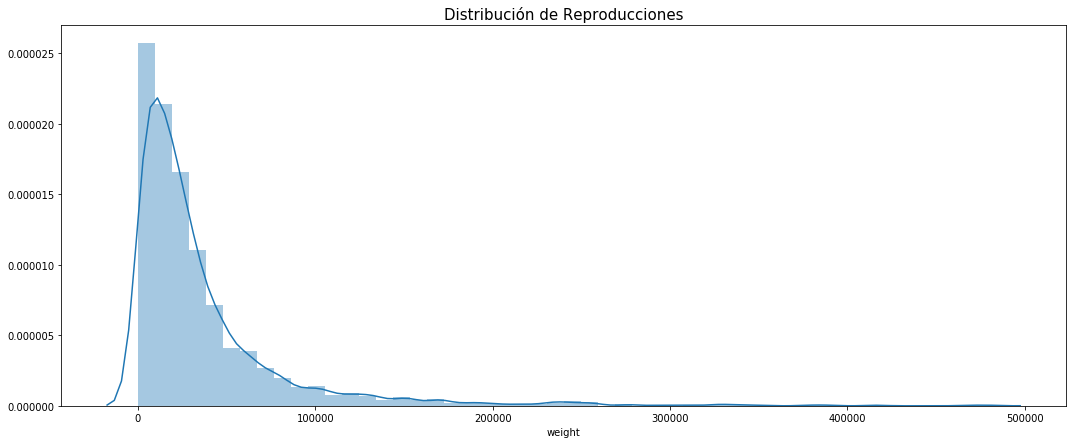

In [6]:
#¿Cómo es la distribución de cantidad de listens por user?

display(pd.pivot_table(user_artist_plays, index = ['userID'], values = ['weight'], aggfunc = sum, fill_value = 0).describe().T)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (18, 7))

plt.title('Distribución de Reproducciones', fontsize = 15)
sns.distplot(pd.pivot_table(user_artist_plays, index = ['userID'], values = ['weight'], aggfunc = sum, fill_value = 0).weight)

plt.show()


In [7]:
#¿Es posible ver el género más escuchado?

tags_dat = pd.read_csv('C:/Users/Flavio/Downloads/hetrec2011-lastfm-2k/tags.dat', sep = '\t', encoding = 'latin-1')
tags_dicc = pd.Series(tags_dat.tagValue.values, index = tags_dat.tagID).to_dict()

user_taggedartists_dat = pd.read_csv('C:/Users/Flavio/Downloads/hetrec2011-lastfm-2k/user_taggedartists.dat', sep = '\t')

top10_tag = pd.DataFrame(user_taggedartists_dat.tagID.value_counts())[0:10].reset_index().rename(columns = {'index':'id', 'tagID':'repro'})
top10_tag.insert(1, 'name', top10_tag.id.map(tags_dicc))

top10_tag


id              name  repro
0   73              rock   7503
1   24               pop   5418
2   79       alternative   5251
3   18        electronic   4672
4   81             indie   4458
5  130  female vocalists   4228
6   25               80s   2791
7   39             dance   2739
8   78  alternative rock   2631
9  192      classic rock   2287

## Ejercicio 2 - Matriz de Usuario-Contenido

En este ejercicio, a partir del conjunto de datos, deberán generar una matriz de usuario-contenido. Tengan en cuenta que los ratings, en este caso, son implícitos, puesto que se dan a partir de la cantidad de veces que un usuario escuchó a cierto artista.

In [8]:
#mapeamos tabla user_artist_plays con nombre del artista...

all_artist_dicc = pd.Series(artist_data.name.values, index = artist_data.id).to_dict()

user_artist_plays_map = user_artist_plays.copy()
user_artist_plays_map.insert(2, 'name', user_artist_plays_map.artistID.map(all_artist_dicc))

user_artist_plays_map


userID  artistID                 name  weight
0           2        51          Duran Duran   13883
1           2        52            Morcheeba   11690
2           2        53                  Air   11351
3           2        54         Hooverphonic   10300
4           2        55        Kylie Minogue    8983
...       ...       ...                  ...     ...
92829    2100     18726            Nyktalgia     337
92830    2100     18727     Atsakau  niekadA     297
92831    2100     18728   Domantas Razauskas     281
92832    2100     18729              Atalyja     280
92833    2100     18730  Les Chants de Nihil     263

[92834 rows x 4 columns]

In [9]:
#nombres únicos...

print(user_artist_plays_map.name.nunique())
print(user_artist_plays_map.artistID.nunique())


17632
17632


In [10]:
#pivoteamos user_artist_plays_map para generar una matriz usuario-contenido (dispersa)...

mtrx_user_artist_plays = pd.pivot_table(user_artist_plays_map, index = ['userID'], columns = ['artistID'], values = ['weight'], aggfunc = sum, fill_value = 0)
mtrx_user_artist_plays


weight                                                        ...  \
artistID  1     2     3     4     5     6     7     8     9     10     ...   
userID                                                                 ...   
2             0     0     0     0     0     0     0     0     0     0  ...   
3             0     0     0     0     0     0     0     0     0     0  ...   
4             0     0     0     0     0     0     0     0     0     0  ...   
5             0     0     0     0     0     0     0     0     0     0  ...   
6             0     0     0     0     0     0     0     0     0     0  ...   
...         ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
2095          0     0     0     0     0     0     0     0     0     0  ...   
2096          0     0     0     0     0     0     0     0     0     0  ...   
2097          0     0     0     0     0     0     0     0     0     0  ...   
2099          0     0     0     0     0     0     0     0     0     0  ...   
2100          0     0   408     0     0   404     0     0     0     0  ...   

                                                                      
artistID 18736 18737 18738 18739 18740 18741 18742 18743 18744 18745  
userID                                                                
2            0     0     0     0     0     0     0     0     0     0  
3            0     0     0     0     0     0     0     0     0     0  
4            0     0     0     0     0     0     0     0     0     0  
5            0     0     0     0     0     0     0     0     0     0  
6            0     0     0     0     0     0     0     0     0     0  
...        ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  
2095         0     0     0     0     0     0     0     0     0     0  
2096         0     0     0     0     0     0     0     0     0     0  
2097         0     0     0     0     0     0     0     0     0     0  
2099         0     0     0     0     0     0     0     0     0     0  
2100         0     0     0     0     0     0     0     0     0     0  

[1892 rows x 17632 columns]

In [11]:
#acomodamos las columnas...

mtrx_user_artist_plays.columns = all_artist_dicc.values()
#mtrx_user_artist_plays.reset_index(inplace = True)

mtrx_user_artist_plays


MALICE MIZER  Diary of Dreams  Carpathian Forest  Moi dix Mois  \
userID                                                                   
2                  0                0                  0             0   
3                  0                0                  0             0   
4                  0                0                  0             0   
5                  0                0                  0             0   
6                  0                0                  0             0   
...              ...              ...                ...           ...   
2095               0                0                  0             0   
2096               0                0                  0             0   
2097               0                0                  0             0   
2099               0                0                  0             0   
2100               0                0                408             0   

        Bella Morte  Moonspell  Marilyn Manson  DIR EN GREY  Combichrist  \
userID                                                                     
2                 0          0               0            0            0   
3                 0          0               0            0            0   
4                 0          0               0            0            0   
5                 0          0               0            0            0   
6                 0          0               0            0            0   
...             ...        ...             ...          ...          ...   
2095              0          0               0            0            0   
2096              0          0               0            0            0   
2097              0          0               0            0            0   
2099              0          0               0            0            0   
2100              0        404               0            0            0   

        Grendel  ...  LOSTFREEQ  Ciccone Youth  Cubanate  Apollo 440  \
userID           ...                                                   
2             0  ...          0              0         0           0   
3             0  ...          0              0         0           0   
4             0  ...          0              0         0           0   
5             0  ...          0              0         0           0   
6             0  ...          0              0         0           0   
...         ...  ...        ...            ...       ...         ...   
2095          0  ...          0              0         0           0   
2096          0  ...          0              0         0           0   
2097          0  ...          0              0         0           0   
2099          0  ...          0              0         0           0   
2100          0  ...          0              0         0           0   

        Die Krupps  Diamanda Galás  Aya RL  Coptic Rain  Oz Alchemist  \
userID                                                                  
2                0               0       0            0             0   
3                0               0       0            0             0   
4                0               0       0            0             0   
5                0               0       0            0             0   
6                0               0       0            0             0   
...            ...             ...     ...          ...           ...   
2095             0               0       0            0             0   
2096             0               0       0            0             0   
2097             0               0       0            0             0   
2099             0               0       0            0             0   
2100             0               0       0            0             0   

        Grzegorz Tomczak  
userID                    
2                      0  
3                      0  
4                      0  
5                      0  
6      

In [12]:
#calculamos la dispersión dividiendo el número de elementos almacenados por el número total de elementos...

n_tot = mtrx_user_artist_plays.shape[0] * mtrx_user_artist_plays.shape[1]
n_rat = mtrx_user_artist_plays.astype(bool).sum().sum()
sparsity = n_rat / n_tot

print(f'Matrix sparsity: {round(sparsity * 100, 2)}%')


Matrix sparsity: 0.28%


## Ejercicio 3 - Entrenamiento del algoritmo de recomendación

Utilizando las herramientas brindadas por Surpr!se, entrenen varios modelos de sistemas de recomendación basados en filtrado colaborativo a partir de su matriz de usuario-contenido. Recuerden tener en cuenta lo aprendido en la diplomatura a la hora de evaluar y validar el modelo.

Si necesitan inspiración, les recomiendo revisar [este notebook con información de como entrenar un sistema de recomendación con Surpr!se](https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Building%20Recommender%20System%20with%20Surprise.ipynb).

In [13]:
#más paquetería...

from surprise import Dataset, Reader
from surprise.accuracy import rmse
from surprise.model_selection import cross_validate, train_test_split
from surprise import SVD
from surprise import SVDpp
from surprise import SlopeOne
from surprise import NMF
from surprise import NormalPredictor
from surprise import KNNBaseline
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import BaselineOnly
from surprise import CoClustering

reader = Reader(rating_scale = (user_artist_plays.weight.min(), user_artist_plays.weight.max()))

ratings = Dataset.load_from_df(user_artist_plays[['userID', 'artistID', 'weight']], reader)


In [14]:
#ponemos a competir modelos...

benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, ratings, measures = ['RMSE'], cv = 5, verbose = False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis = 0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index = ['Algorithm']))
    benchmark.append(tmp)


Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Don

In [15]:
#¿cuál califica mejor?...

surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
surprise_results


test_rmse   fit_time  test_time
Algorithm                                           
BaselineOnly       3650.691633   0.410308   0.171724
SlopeOne           3666.827041  12.595483   1.151312
NMF                3757.841959   8.886672   0.200073
KNNWithZScore      4341.902593   1.107203   3.665624
KNNWithMeans       4521.621876   0.890503   2.805697
KNNBaseline        4571.082803   1.022060   3.206440
KNNBasic           4580.838752   0.732628   2.418356
NormalPredictor    4585.138148   0.162483   0.187000
CoClustering       5076.618880   5.461052   0.174606
SVDpp            351961.395229  62.776850   1.302756
SVD              351961.395715   6.590132   0.201999

In [16]:
#el ganador es: BaselineOnly...

model = BaselineOnly()

ratings_train, ratings_test = train_test_split(ratings, test_size = 0.2)

predictions = model.fit(ratings_train).test(ratings_test)

print("RMSE on test: {:.4f}".format(rmse(predictions, verbose = False)))


Estimating biases using als...
RMSE on test: 2588.4229


## Ejercicio 4 - Sistema de recomendación

A partir del mejor modelo de recomendación que hayan sugerido en el caso anterior, y utilizando los datos del archivo `artist.dat`, armar un sistema de recomendación sencillo que, dado un nombre de un artista, devuelva el top 10 de artistas más similares.

La idea es que el sistema tome el nombre de un artista y devuelva el nombre de otros artistas (no simplemente tomar y devolver IDs). Se recomienda [revisar este notebook para inspiración (ver el paso número 5)](https://github.com/topspinj/pydata-workshop/blob/master/tutorial.ipynb).

In [17]:
#

user_artist_plays[['userID', 'artistID', 'weight']].head()


userID  artistID  weight
0       2        51   13883
1       2        52   11690
2       2        53   11351
3       2        54   10300
4       2        55    8983

In [18]:
#utilizaremos filtrado colaborativo para generar recomendaciones (a personas similares les gustan cosas similares)...
#... llevamos la data a una matriz usuario-item.

from scipy.sparse import csr_matrix

def create_X(df):
    """
    Generates a sparse matrix from ratings dataframe.
    
    Args:
        df: pandas dataframe containing 3 columns (userId, movieId, rating)
    
    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        artist_mapper: dict that maps movie id's to artist indices
        artist_inv_mapper: dict that maps movie indices to artist id's
    """
    M = df['userID'].nunique()
    N = df['artistID'].nunique()

    user_mapper = dict(zip(np.unique(df['userID']), list(range(M))))
    artist_mapper = dict(zip(np.unique(df['artistID']), list(range(N))))
    
    user_inv_mapper = dict(zip(list(range(M)), np.unique(df['userID'])))
    artist_inv_mapper = dict(zip(list(range(N)), np.unique(df['artistID'])))
    
    user_index = [user_mapper[i] for i in df['userID']]
    item_index = [artist_mapper[i] for i in df['artistID']]

    X = csr_matrix((df['weight'], (user_index, item_index)), shape = (M, N))
    
    return X, user_mapper, artist_mapper, user_inv_mapper, artist_inv_mapper

X, user_mapper, artist_mapper, user_inv_mapper, artist_inv_mapper = create_X(user_artist_plays)


In [19]:
#calculamos la dispersión dividiendo el número de elementos almacenados por el número total de elementos...
#... X.nnz cuenta los valores no zeros.

n_total = X.shape[0] * X.shape[1]
n_ratings = X.nnz
sparsity = n_ratings / n_total

print(f'Matrix sparsity: {round(sparsity * 100, 2)}%')


Matrix sparsity: 0.28%


In [20]:
#item-item Recommendations with k-Nearest Neighbors...

from sklearn.neighbors import NearestNeighbors

def find_similar_artists(artist_id, X, artist_mapper, artist_inv_mapper, k, metric = 'cosine'):
    """
    Finds k-nearest neighbours for a given movie id.
    
    Args:
        movie_id: id of the movie of interest
        X: user-item utility matrix
        k: number of similar movies to retrieve
        metric: distance metric for kNN calculations
    
    Output: returns list of k similar movie ID's
    """
    X = X.T
    neighbour_ids = []
    
    artist_ind = artist_mapper[artist_id]
    artist_vec = X[artist_ind]
    
    if isinstance(artist_vec, (np.ndarray)):
        artist_vec = artist_vec.reshape(1,-1)
        
    # use k+1 since kNN output includes the artistID of interest
    kNN = NearestNeighbors(n_neighbors = k + 1, algorithm = 'brute', metric = metric)
    kNN.fit(X)
    neighbour = kNN.kneighbors(artist_vec, return_distance = False)
    
    for i in range(0, k):
        n = neighbour.item(i)
        neighbour_ids.append(artist_inv_mapper[n])
        
    neighbour_ids.pop(0)
    return neighbour_ids

def artist_finder(artist):
    return artist_data[artist_data['name'].str.contains(artist)]['name'].tolist()

artist_idx = dict(zip(artist_data['name'], list(artist_data.id)))

#artist_idx = dict(zip(list(artist_data.index), artist_data['name']))


In [21]:
#10 recomendaciones para...

name = artist_finder('Lady Gaga')[0]
n_recommendations = 10

idx = artist_idx[name]
similar_artists = find_similar_artists(idx, X, artist_mapper, artist_inv_mapper, k = n_recommendations)

print('Recomendaciones para {} ({}):'.format(name, idx))
print()
for i in similar_artists:
    print('-', list(artist_idx.keys())[list(artist_idx.values()).index(i)], '(' + str(i) + ')')


Recomendaciones para Lady Gaga (89):

- Tom Felton (12574)
- A Bullet for Pretty Boy (14449)
- Massacre On The Dancefloor (14441)
- Fagasaurus Sex (14442)
- This Romantic Tragedy (8682)
- B is for Bloodbath (14447)
- Dying Diva (14448)
- White Lilium (14446)
- Low Shoulder (7943)
